# Assignment 1: Classification

Machine Learning for Finance  
VU Amsterdam    

**Instructors**  
Iman van Lelyveld (iman.van.lelyveld@vu.nl)  
Dieter Wang (d.wang@vu.nl)  

<span style='color:crimson; font-weight: bold'>Submission deadline: 13 Nov 2019, 6pm CET</span>

## Instructions
* Each group submits _only one_ notebook via canvas on the assignment page.  
Not a zip folder, not the data, only one notebook file.
* The notebook should be named `assignment1_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `assignment1_group03.ipynb`.  
* The notebook should run without raising any errors.
* We recommend the folder structure
```
assignment/
-- 1_data/
-- 2_code/
-- 3_results/
-- assignment1_groupXX.ipynb
```
* We strongly recommend git, as you are encouraged to collaborate and split up the work and maybe even start independently. To see how to set up your own repo for your group, see `L2-git-slides.pdf`, slides 20 onwards.
* Do not spend time on optimizing the speed of your code.
* We strongly encourage you to experiment, try different approaches and combinations and get to know the problem from alternative angles. But the final notebook should only contain the necessary results for grading.

In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

## Introduction

What determines sovereign credit ratings?

In this assignment you will classify country ratings based on observable charateristics. We use the Standard & Poor's Long-term bond ratings (AAA+ to D) for 108 countries. We do not use them directly but instead transform them into [EU Credit Quality Step](https://en.wikipedia.org/wiki/Credit_rating#Corporate_credit_ratings) ranging from 1 (AAA+) to 6 (D). This is stored in the column `cqs`. To facilitate the classification task, we further subdivide them into 
* `cqs_group3` has the values `rating_high=1`,`rating_medium=2` and `rating_low=3`
* `cqs_group2` has the values `rating_high=1` and `rating_low=2`

You can inspect the data to find out how `cqs`, `cqs_group2` and `cqs_group3` relate to each other.

To classify the countries, you will find the seven following features. For variable descriptions, you can visit [World Bank's World Development Indicators](http://datatopics.worldbank.org/world-development-indicators/)

In [347]:
all_features = {
    'co2':            'CO2 emissions (metric tons per capita)',
    'doctors':        'Physicians (per 1,000 people)',
    'urban_pop':      'Urban population (% of total)',
    'cellular':       'Mobile cellular subscriptions (per 100 people)',
    'deaths_infant':  'Mortality rate, under-5 (per 1,000 live births)',
    'age_dep':        'Age dependency ratio (% of working-age population)',
    'gni_growth':     'GNI growth (annual %)',
}

Let's load and have a look at the data

In [348]:
path = os.path.join('..','1_data','country_data.csv')

df_data = pd.read_csv(path)
df_data = df_data.set_index('iso3')

df_data.head(10)

cqs  cqs_group3  cqs_group2        co2   doctors  urban_pop    cellular  \
iso3                                                                            
AGO     5           3           2   1.028785  0.105500  58.258000   28.072494   
ALB     5           3           2   1.458028  1.255875  50.511333   75.836536   
ARE     1           1           1  24.222283  1.638429  83.441667  130.895154   
ARG     5           3           2   4.218718  3.344800  90.545000   97.487009   
AUS     1           1           1  17.207837  2.991500  84.992556   93.177440   
AUT     1           1           1   8.095118  4.272615  58.319500  126.768677   
AZE     4           2           2   3.791675  3.564545  53.192000   66.108836   
BEL     1           1           1   9.890098  3.050455  97.566278   97.943300   
BFA     5           3           2   0.116257  0.041250  23.564611   34.163700   
BGD     4           2           2   0.328752  0.342308  29.469500   37.960973   

      deaths_infant    age_dep  gni_growth  
iso3                                        
AGO      138.577778  98.531807    7.811246  
ALB       14.605556  50.709464    4.323332  
ARE        9.283333  21.663903    3.995919  
ARG       14.972222  58.001031    2.533325  
AUS        4.988889  49.341731    2.953411  
AUT        4.494444  48.149027    1.691040  
AZE       43.950000  45.642867   12.146821  
BEL        4.711111  52.924934    1.523743  
BFA      129.083333  95.206465    5.388608  
BGD       56.116667  59.696138    6.014959

## Preparation

Before we start the analysis, we prepare the data by labelling them correctly and splitting into targets and features. We will start with a binary classification (`cqs_group2`).

In [349]:
target_name = 'cqs_group2'
# `sr_` prefix stands for a pandas Series
sr_targets = df_data.loc[:,target_name]

These targets can take on two values.

In [350]:
label_values = [1,2]
label_names = ['rating_high', 'rating_low'] 

The features are as described above. Let us use the short names from now on and extract those from the dataset.

In [351]:
selected = list(all_features.keys())

# `df_` prefix stands for a pandas DataFrame
df_features = df_data.loc[:,selected]

# Question 1
**10 points**

Import the function `plot_pairwise_scatter` from `lib.plots` and visualize how the variables relate to each other. The function is used as follows
```
plot_pairwise_scatter(sr_targets, df_features, label_values)
```

Describe the data in words. What variables do you expect to be important for the classification? You can argue using economic, financial or statistical arguments. 

Furthermore, do you need to pre-process your data? If so, what type of preprocessing may be appropriate or even necessary here?

In [352]:
#Plot variables as scatterplots against each other and seperate observations based on binary label in cqs_group2
#From the plots we observe that the data is not normally distributed for any variable.

from lib.plots import plot_pairwise_scatter
plot_pairwise_scatter(sr_targets, df_features, label_values)

/Users/yushengwu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [353]:
#To make the data more 'normal' we have decided to take the log of all variables. 
#Take the log distribution to pre-process the data.

df_features_log = np.log(df_features)
plot_pairwise_scatter(sr_targets, df_features_log, label_values)

/Users/yushengwu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


**Answer**: The variables that we think will be important for classification are deaths_infant and gni_growth. GNI_growth is the growth national income growth, which is simply GDP plus income from the country´s residents earned abroad. We expect this factor to be negatively related to a sovereign´s credit rating, as high growth is an important characteristic of emerging markets . The number of deaths among infants can serve as a proxy of a nations socioeconomic development. We expect that the number of deaths among infants is inversely related to sovereign credit rating. 

# Question 2
**10 points**

Based on your arguments in Question 1, decide for two features. These two features `feature1, feature2` will be your inputs for the subsequent classifications.

Make a plot and describe what a linear classifier is likely to do. What challenges could it run into? 

In [354]:
feature1 = 'gni_growth'
feature2 = 'deaths_infant'

In [355]:
df_features_log['cqs_group2'] = df_data['cqs_group2']
df_features_log.head()

co2   doctors  urban_pop  cellular  deaths_infant   age_dep  \
iso3                                                                     
AGO   0.028379 -2.249044   4.064881  3.334790       4.931432  4.590379   
ALB   0.377085  0.227833   3.922198  4.328580       2.681402  3.926113   
ARE   3.187273  0.493738   4.424148  4.874397       2.228221  3.075647   
ARG   1.439531  1.207407   4.505847  4.579719       2.706197  4.060461   
AUS   2.845365  1.095775   4.442564  4.534506       1.607213  3.898770   

      gni_growth  cqs_group2  
iso3                          
AGO     2.055564           2  
ALB     1.464026           2  
ARE     1.385274           1  
ARG     0.929533           2  
AUS     1.082961           1

In [356]:
plt.scatter(df_features_log[feature1][df_features_log.cqs_group2 == 1], df_features_log[feature2][df_features_log.cqs_group2 == 1], c='Blue')
plt.scatter(df_features_log[feature1][df_features_log.cqs_group2 == 2], df_features_log[feature2][df_features_log.cqs_group2 == 2], c='Red')

**Answer:** Looking at the scatterplot, we would expect the linear classifier to draw a line between the blue and red observations, which would look like a line sloping upwards with a negative intercept. this line would intercept the x axis at approximately -1.2 and will be drawn till (2.5, 3.2) Optically, this would seperate the red from the blue (the low from the high ratings) most accurately. 

Since the observations for either a low or high rating have high dispersion we expect the line of the linear classifier to underfit. Due to this, we will face the challenge of high bias because some of the variance is not taken into account. 

From the scatterplot we can see that the relationship between the variables is non-linear, which is problematic for a linear support vector machine. A radial (non-linear) vector machine might be a more appropriate classifier. 

---

# Question 3
**15 points**

Use a linear support vector machine from the `sklearn.svm` module and plot the results. 

For the plot, import `plot_classification_contours` from `lib.plots`. Use it like this
```
plot_classification_contours(X, y, clf, [feature1,feature2])
```
where `clf` is the sklearn classifier object. `X` is a numpy array with `[n_obs, n_features]` dimensions and `y` is a numpy array with `[n_obs,]` dimensions.

**Hint:** You can leave the default options of your classifier. But if you decide to adjust them, please give an explanation.

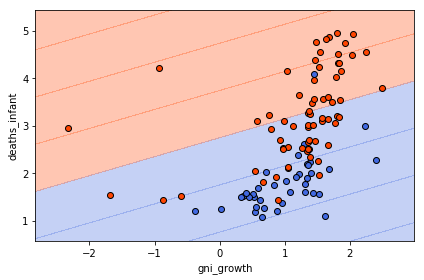

In [357]:
#Import neccessary modules

from lib.plots import plot_classification_contours
import sklearn.svm as svm

X = np.array(df_features_log.loc[:, [feature1,feature2]])
y = np.array(sr_targets)

# fit the linear classifier
clf_linear = svm.SVC(kernel='linear').fit(X, y)

#Plot the linear classifier

plot_classification_contours(X, y, clf_linear, [feature1,feature2]);

# Question 4
**25 points**

How well did the classification go? 

Make predictions and call them `y_pred`. Write four functions to compute the four elements of a confusion matrix. Name them appropriately and cross check their results with the output of the following plot
```
plot_confusion_matrix(y, y_pred, label_names, normalize=True)
```
Once again, you can import this function from `lib.plots`.

Furthermore, write two functions to compute the precision and recall of your classifier. 

**Hint:** The functions you write should have the following structure:
```
def true_positive(y_true, y_pred):
    # magic
    return TP
```
It is important here that `y_true` and `y_pred` follow the same binary classifications and agree on what's "positive" and whats "negative".

**Answer**: The classification in question 3 using a linear classifier didn't perform well as can be observed in the graph. Many observations represented by red dots are in the blue area and vice versa. There are many red dots underneath the blue line which can be marked as false positives.  

In [358]:
## Your answer
from lib.plots import plot_confusion_matrix

y_pred = clf_linear.predict(X)
# four functions for the four elements of confusion matrix

def true_negative(y, y_pred):
    TP = 0
    for i in range(len(y)): 
        if y[i]==y_pred[i]==2:
               TP += 1
    return(TP)

def false_negative(y, y_pred):
    FP = 0
    for i in range(len(y)):
        if y_pred[i]==2 and y[i]!=y_pred[i]:
               FP += 1
    return(FP)

def true_positive(y, y_pred):
    TN = 0
    for i in range(len(y)):
        if y[i]==y_pred[i]==1:
            TN += 1
    return(TN)

def false_positive(y,y_pred):
    FN = 0
    for i in range(len(y)):
        if y_pred[i]==1 and y[i]!=y_pred[i]:
               FN += 1
    return (FN)


plot_confusion_matrix(y, y_pred, label_names, normalize=True)

Normalized confusion matrix
[[0.8974359  0.1025641 ]
 [0.10144928 0.89855072]]


In [359]:
# cross check
print ("True positive is: " + str(true_positive(y, y_pred)))
print ("False positive is: " + str(false_positive(y, y_pred)))
print ("True negative is: " + str(true_negative(y, y_pred)))
print ("False negative is: " + str(false_negative(y, y_pred)))

# values are in line with the confusion matrix

True positive is: 35
False positive is: 7
True negative is: 62
False negative is: 4


In [360]:
plot_confusion_matrix(y, y_pred, label_names, normalize=False)

Confusion matrix, without normalization
[[35  4]
 [ 7 62]]


In [361]:
# precision and recall

def precision(y, y_pred):
    precision = true_positive(y, y_pred)/(true_positive(y, y_pred) + false_positive(y, y_pred))
    return "The precision is " + str(precision)

def recall(y, y_pred):
    recall = true_positive(y, y_pred)/(true_positive(y, y_pred) + false_negative(y, y_pred))    
    return "The recall is " + str(recall)

print(precision(y, y_pred))
print(recall(y, y_pred))

The precision is 0.8333333333333334
The recall is 0.8974358974358975


# Question 5
**15 points**

Change the classifier to a radial basis function and discuss the results. Does it do better than the linear classifier? If so, in what respect? If not, why? Is the confusion matrix different?

**Hint:** In sklearn, the `gamma` parameter may need some adjustment, depending on your features.

In [362]:
# fit the radial classifier
clf_radial = svm.SVC(gamma="auto", kernel='rbf').fit(X, y)
plot_classification_contours(X, y, clf, [feature1,feature2]);

Normalized confusion matrix
[[0.87179487 0.12820513]
 [0.10144928 0.89855072]]


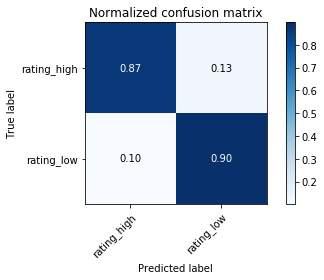

In [363]:
y_pred_radial = clf_radial.predict(X)
plot_confusion_matrix(y, y_pred_radial, label_names, normalize=True);

**Answer:** From the graphical representation, we would say that the radial classifier does a better job at classifying. However, the confusion matrix shows otherwise: the radial classifier has less precision and therefore a lower True positive ratio compared to the linear classifier. Gamma with different values do affect the accuracy, however, the default number (1/n_features) works well.

---

# Question 6
**15 points**

Let us now consider a third feature `feature3` as an additional predictor variable. Look at the previous pairplot for this purpose and identify a third input.

In [364]:
feature3 = 'age_dep'

# Age dependency is added as a third feature

You can again visualize the three features using 
```
selected = [feature1,feature2,feature3]
plot_pairwise_scatter(sr_targets, df_features.loc[:,selected], label_values)
```

Use this new feature and rerun the classification. Does the new feature improve the predictions, or is it possible that it does worse? Please explain.

/Users/yushengwu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


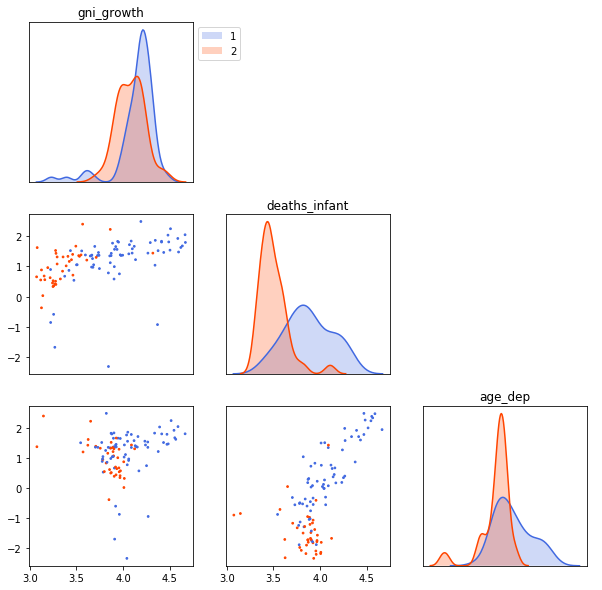

In [365]:
#Generate a pairplot that includes the third feature

selected_Q6 = [feature1,feature2,feature3]
plot_pairwise_scatter(sr_targets, df_features_log.loc[:,selected_Q6], label_values)

Normalized confusion matrix
[[0.8974359  0.1025641 ]
 [0.11594203 0.88405797]]


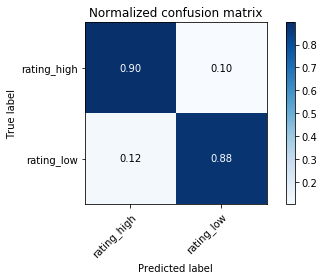

In [366]:
# prediction with 3 features

X_3features = np.array(df_features_log.loc[:, [feature1,feature2, feature3]])
y = np.array(sr_targets)

clf_3features = svm.SVC(gamma="auto").fit(X_3features, y)

y_pred_3features = clf_3features.predict(X_3features)

plot_confusion_matrix(y, y_pred_3features, label_names, normalize=True);

In [367]:
print("Three features: " + str(precision(y, y_pred_3features)))
print("Three features: " + str(recall(y, y_pred_3features)))
print (" ")
print ("Two features: " + str(precision(y, y_pred)))
print ("Two features: " + str(recall(y, y_pred)))

Three features: The precision is 0.813953488372093
Three features: The recall is 0.8974358974358975
 
Two features: The precision is 0.8333333333333334
Two features: The recall is 0.8974358974358975


**Answer**: based on the scatterplot, it will be harder to draw a line to distinct between high and low credit rating. This is because there is more overlap in the scatterplots and normal distribution. Based on the recall ratio, the three feature model found less true positives in the three feature model than in the two feature model.

# Question 7
**10 points**

Finally, let us switch from a binary classification to a classification of three outcomes. This corresponds to the columns `cqs_group3`, where we have `rating_high`, `rating_medium` and `rating_low`.

In [368]:
target_name = 'cqs_group3'
sr_targets_q7 = df_data.loc[:,target_name]

In [369]:
label_values_q7 = [1,2,3]
label_names_q7 = ['rating_high', 'rating_mid', 'rating_low']

/Users/yushengwu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


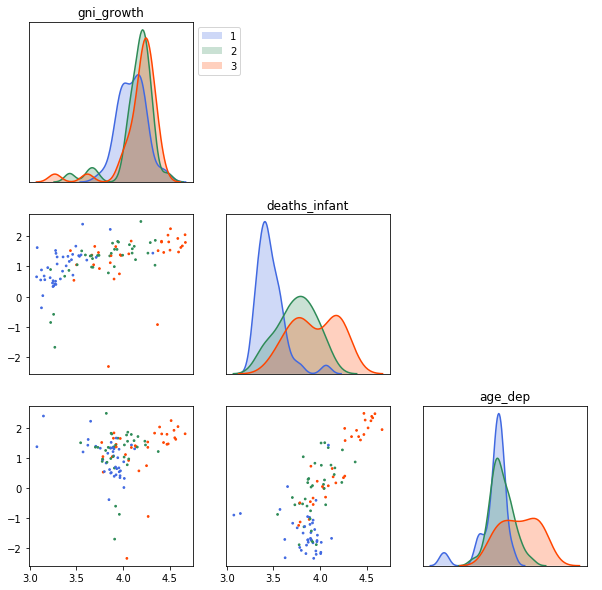

In [370]:
y_q7 = np.array(sr_targets_q7)
selected_q7 = [feature1,feature2,feature3]
plot_pairwise_scatter(sr_targets_q7, df_features_log.loc[:,selected_Q6], label_values_q7)

To evaluate the results of the pairplot, we cannot use the contours function we used previously because this function only allows two features for visual 

You can again use the 
```
selected = [feature1,feature2,feature3]
plot_pairwise_scatter(sr_targets, df_features.loc[:,selected], label_values)
```
command to visualize your data.

Inspect the classification results. Can you use the functions you defined previously to asses the results, or do you need to make adjustments? If so, do you have to completely rewrite the functions or are only minor adjustments necessary?

**Answer**: The contours function gives us a 2D graphical representation of the results. If we had just 3 targets(high,medium low) and only two features, we would have been able to make minor adjustments to the code to let it allow to classify the three targets given the two features on x and y axis. Since we also have three features, we need a 3D model with additional "z" axis to be able to plot all the three features as input. This means minor adjustments won't be enough to plot the contours correspondent to the scatterplot above.

## Bonus question
**10 points**
Compute the confusion matrix.  
Compute precision and recall for this case.

Normalized confusion matrix
[[0.92307692 0.05128205 0.02564103]
 [0.16666667 0.77777778 0.05555556]
 [0.09090909 0.42424242 0.48484848]]


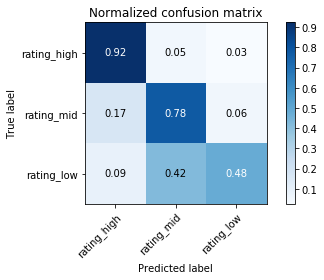

In [371]:
## Your answer
clf_q7 = svm.SVC(gamma="auto").fit(X_3features, y_q7)
y_pred_q7 = clf_q7.predict(X_3features)
plot_confusion_matrix(y_q7, y_pred_q7, label_names_q7, normalize=True);

In [372]:
# import confusion matrix from sklearn and use it to calculate the precision and recall
from sklearn.metrics import confusion_matrix

def precision3(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    # precision is true positive / (true positive + false positive)
    prec = cm[0,0]/(cm[0,0]+cm[1,0] + cm[2, 0])
    return print('the precision is :', prec)

def recall3(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    #recall = true positive / (true positive + false negative)
    rec = cm[0,0]/(cm[0,0]+cm[0,1] + cm[0,2])
    return print('the recall is: ', rec)

# check the results from the newly created functions
precision3(y_q7, y_pred_q7)
recall3(y_q7, y_pred_q7)

the precision is : 0.8
the recall is:  0.9230769230769231


In [373]:
# check the resutls from the functions from question 4
print(precision(y_q7, y_pred_q7))
print(recall(y_q7, y_pred_q7))

The precision is 0.8
The recall is 0.6923076923076923


The precision from question 4 conforms with the result from, precision3, the function using "confusion_matrix".
The recall from question 4 does not conform with the result from, recall3, the function using "confusion_matrix".
Recall3 should be used to calculate the recall for when y has 3 values. 

---